# Noise Hamming weight and Pearson Correlation

This notebook demonstrates how to guess a floating number using Hamming Weight model.

We generate a random secret floating number. Then we use hamming weight model to guess the number.

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint
from guess_range import *

## Visualize HW Behavior

In [2]:
def compute_corr(secret_hw, guess_range, known_inputs, guess_val_size=1000):
    low, high = guess_range
    guess_val = np.arange(low, high, (high - low) / (guess_val_size - 1e-6))
    hw = pd.DataFrame(columns=guess_val,
                        data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_val))
    return hw.corrwith(pd.Series(secret_hw), method='pearson')

In [326]:
guess_range=(-3e0, 3e0)
# the number of guess values in the guess range
guess_val_size=4000
# generate the known inputs which is used to test the guess values
known_inputs = np.random.uniform(-1e2, 1e2, 1000)

secret_number = np.random.uniform(guess_range[0], guess_range[1]) 
secret_number = 6.374345698e-2
print('secret_number =', secret_number)

secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
correlations = compute_corr(secret_hw, guess_range, known_inputs, guess_val_size)
correlations_1 = compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size*10))
correlations_2 = compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size/10))
correlations.sort_values(ascending=False).iloc[:10]

secret_number = 0.06374345698


 0.0630    0.564933
 0.0645    0.555636
-0.0645    0.507943
 0.0615    0.506327
-0.0630    0.506170
 0.0585    0.481033
 0.0600    0.476739
-0.0615    0.466485
 0.0510    0.446736
 0.0675    0.442251
dtype: float64

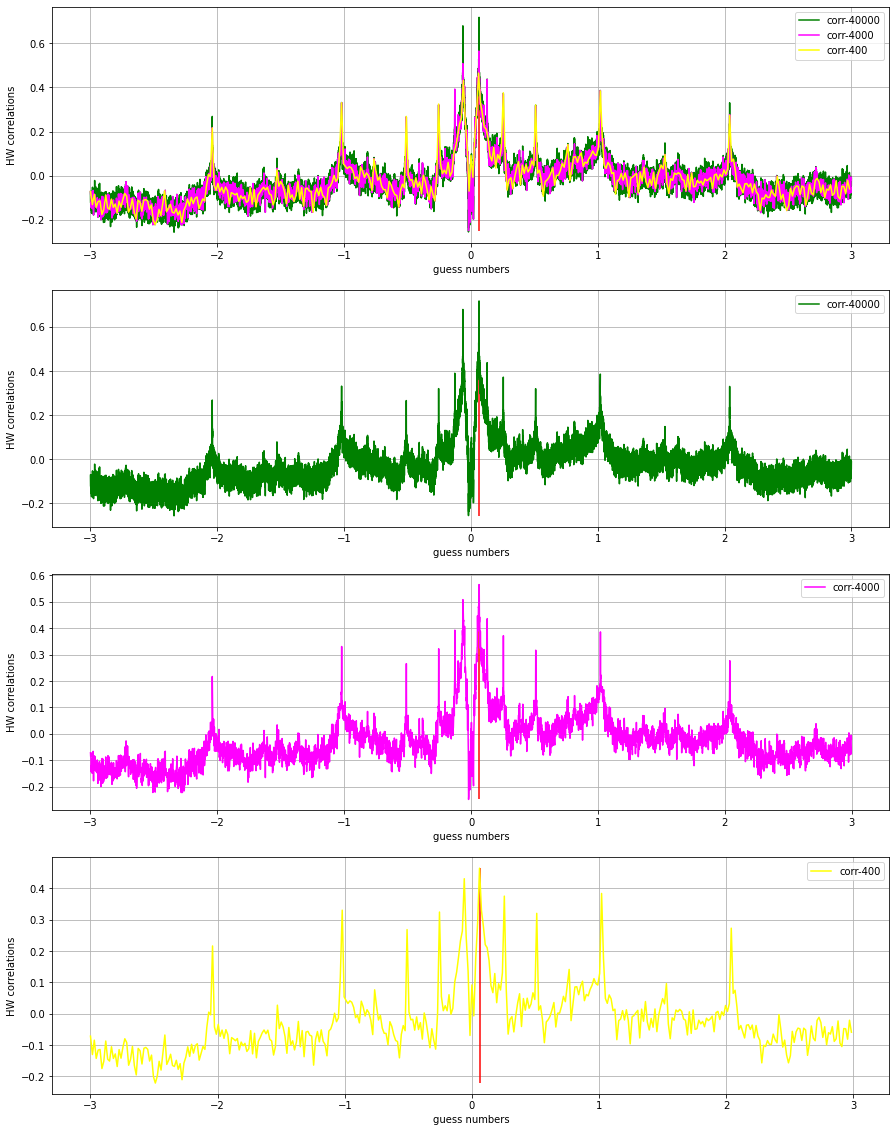

In [327]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 20))
correlations_1.plot(ax=ax[0], label='corr-%s' % correlations_1.shape[0], color='green')
correlations.plot(ax=ax[0], label='corr-%s' % correlations.shape[0], color='magenta')
correlations_2.plot(ax=ax[0], label='corr-%s' % correlations_2.shape[0], color='yellow')
ax[0].vlines(secret_number, correlations.min(), correlations.max(), color='red')

correlations_1.plot(ax=ax[1], label='corr-%s' % correlations_1.shape[0], color='green')
ax[1].vlines(secret_number, correlations_1.min(), correlations_1.max(), color='red')

correlations.plot(ax=ax[2], label='corr-%s' % correlations.shape[0], color='magenta')
ax[2].vlines(secret_number, correlations.min(), correlations.max(), color='red')

correlations_2.plot(ax=ax[3], label='corr-%s' % correlations_2.shape[0], color='yellow')
ax[3].vlines(secret_number, correlations_2.min(), correlations_2.max(), color='red')

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('guess numbers')
    a.set_ylabel('HW correlations')
    
plt.show()

## Analyze with noise - one number

In [328]:
def resize_known_inputs(known_inputs, new_len):
    """
    resize the known input to the new_len
    :param known_inputs: known inputs 
    :param new_len: new size of the know_inputs
    :return: the known
    """
    old_len = len(known_inputs)
    vf = np.vectorize(lambda i: known_inputs[int(i*old_len/new_len)])
    return vf(np.arange(0, new_len))

def add_noise_to_signal(signal, snr):
    """
    add noise to the signal
    :param signal: signal
    :param snr: signal to noise ratio 
    :return: signal with noise
    """
    
    return (signal + np.random.normal(-0.5, 0.5, len(signal))*(np.max(signal)-np.min(signal))*(1.0-snr)/snr)

In [329]:
# the noise frequency is 50 times higher than HW signal frequency. Here we also increase
# the sizes of the computation with 
noise_known_inputs = resize_known_inputs(known_inputs, len(known_inputs) * 50)
no_noise_secret_hw = np.vectorize(hamming_weight)(noise_known_inputs * secret_number)

In [5]:
### Add noise to hamming weight of the multiplication of the secret number
signal_to_noise_ratio = 0.5
noise_secret_hw = add_noise_to_signal(signal=no_noise_secret_hw, snr=signal_to_noise_ratio)
ax = pd.DataFrame([noise_secret_hw, no_noise_secret_hw], index=['noise_secret_hw', 'no_noise_secret_hw']).T.plot(figsize=(15,6))
ax.legend()

NameError: name 'add_noise_to_signal' is not defined

In [4]:
noise_correlations = compute_corr(noise_secret_hw, guess_range, noise_known_inputs, guess_val_size)
print('secret_number =', secret_number)
noise_correlations.sort_values(ascending=False).iloc[:10]

NameError: name 'noise_secret_hw' is not defined

In [2]:
ax = correlations.plot(figsize=(15, 6), label='without noise')
noise_correlations.plot(ax=ax, label='with noise')
ax.vlines(secret_number, 
          min(noise_correlations.min(), correlations.min()),
          max(noise_correlations.max(), correlations.max()), 
          color='red', label='secret value')
ax.legend()

NameError: name 'correlations' is not defined

## Analyze with noise - multiple numbers

In [5]:
def add_noise_to_signal(signal, snr, freq):
    """
    add noise to the signal
    :param signal: signal
    :param snr: signal to noise ratio 
    :param freq: frequency of noise 
    :return: signal with noise
    """
    sig_max = signal.max()
    sig_min = signal.min()
    return signal.apply(lambda x: x  +
                        np.average(np.random.normal(-0.5, 0.5, freq)*(sig_max-sig_min)*(1.0-snr)/snr))

In [6]:
guess_range = (0.0, 5.0)
known_input_set = generate_known_inputs(exps=(-2,3), nsize=3000)
precision = 1e-6
n_secret_numbers = 10
secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers*2/4) ),
    np.random.uniform(guess_range[0]*3e-1, guess_range[1]*3e-1, int(n_secret_numbers*1/4)),
    np.random.uniform(guess_range[0]*1e-1, guess_range[1]*1e-1, int(n_secret_numbers*1/4))
))
np.random.shuffle(secret_numbers)
print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))

secret_numbers.shape = (9,)


In [7]:
secret_numbers_hws = {}
for idx in known_input_set.index:
    secret_numbers_hws[idx] = pd.DataFrame(
        columns=secret_numbers, 
        data=np.vectorize(hamming_weight)(np.asarray(known_input_set.loc[idx]).reshape(-1, 1) * secret_numbers))

In [8]:
secret_numbers_hws[0]

,1.464827,0.494385,0.312592,2.589412,0.879303,4.894169,0.146355,0.277339,0.470359
0,17,20,18,11,15,12,19,21,15
1,16,15,17,16,18,19,14,20,13
2,19,17,19,24,16,8,16,21,17
3,22,17,14,17,18,19,18,19,12
4,22,13,20,17,17,9,16,18,17
...,...,...,...,...,...,...,...,...,...
495,18,13,14,17,19,13,19,20,17
496,16,16,13,20,17,23,19,21,22
497,22,18,15,16,14,18,15,15,13
498,21,17,15,18,21,13,13,17,17


In [9]:
SECRET_VALUE='secret value'
df_index = [INPUT_ID, LOW_VALUE, HIGH_VALUE, CORRELATION, SECRET_VALUE]

In [10]:
%%time
# start guessing... - without noise first
results = pd.DataFrame()
for value in secret_numbers:
    for kidx in known_input_set.index:
        l, h, c = guess_number_range(secret_numbers_hws[kidx][value], guess_range, precision, known_input_set.loc[kidx])
        pprint('[%.06f] %02d %.06f %.06f %.06f' % (value, kidx, l, h, c))
        results = pd.concat([results, pd.Series([kidx, l, h, c, value], index=df_index)], axis=1, ignore_index=True)

'[1.464827] -2 1.464844 1.464845 0.640795'
'[1.464827] -1 1.464847 1.464847 0.662647'
'[1.464827] 00 1.464845 1.464846 0.569189'
'[1.464827] 01 1.464851 1.464852 0.738621'
'[1.464827] 02 0.000000 0.000001 0.276193'
'[1.464827] 03 1.464844 1.464844 0.615243'
'[0.494385] -2 0.494385 0.494385 0.998470'
'[0.494385] -1 0.494385 0.494385 0.998832'
'[0.494385] 00 0.494385 0.494385 0.999540'
'[0.494385] 01 0.494385 0.494385 0.997582'
'[0.494385] 02 0.494385 0.494385 0.999497'
'[0.494385] 03 0.494385 0.494385 0.998136'
'[0.312592] -2 0.312592 0.312592 0.999662'
'[0.312592] -1 0.312592 0.312592 0.999845'
'[0.312592] 00 0.312592 0.312592 1.000000'
'[0.312592] 01 0.312592 0.312592 1.000000'
'[0.312592] 02 0.312592 0.312592 0.999868'
'[0.312592] 03 0.312592 0.312592 1.000000'
'[2.589412] -2 2.589412 2.589412 0.999851'
'[2.589412] -1 2.589412 2.589412 0.999145'
'[2.589412] 00 2.589412 2.589412 0.999856'
'[2.589412] 01 2.589412 2.589412 0.999539'
'[2.589412] 02 2.589412 2.589412 0.999343'
'[2.589412]

In [18]:
### Add noise to hamming weight of the multiplication of the secret number
signal_to_noise_ratio = 0.5
noise_secret_numbers_hws = {}
for k in secret_numbers_hws.keys():
    noise_secret_numbers_hws[k] = secret_numbers_hws[k].apply(lambda hw: add_noise_to_signal(signal=hw, snr=signal_to_noise_ratio, freq=50), axis=0)
noise_secret_numbers_hws[0]    

,1.464827,0.494385,0.312592,2.589412,0.879303,4.894169,0.146355,0.277339,0.470359
0,9.906105,12.242697,9.381645,0.743369,5.673840,4.621972,8.138618,14.755239,8.610808
1,10.077939,6.686080,9.187779,5.858461,12.262754,9.495036,6.963501,13.884878,7.332784
2,12.372052,10.479204,13.172961,14.647369,8.263832,-2.177456,7.514664,14.913186,10.355529
3,13.438561,8.711146,5.800336,7.816385,10.342726,8.452076,11.367007,11.939785,6.386987
4,15.257442,3.451065,13.230948,11.087450,10.340682,-0.451032,7.690788,13.035702,9.359307
...,...,...,...,...,...,...,...,...,...
495,10.424386,4.578526,5.329865,3.913688,9.740977,5.010223,10.764070,14.614478,11.520146
496,8.029107,9.309359,3.105822,9.997108,9.520500,15.987950,10.074998,14.963906,14.559965
497,14.078435,8.968070,6.756616,3.821087,8.932823,7.815079,8.251393,7.595241,6.476774
498,13.942053,8.850828,5.777335,8.965233,13.941252,4.020145,5.115304,9.762554,10.708658


In [ ]:
%%time
# start guessing... - with noise
noise_results = pd.DataFrame()
for value in secret_numbers:
    for kidx in known_input_set.index:
        l, h, c = guess_number_range(noise_secret_numbers_hws[kidx][value], guess_range, precision, known_input_set.loc[kidx])
        pprint('[%.06f] %02d %.06f %.06f %.06f' % (value, kidx, l, h, c))
        noise_results = pd.concat([noise_results, pd.Series([kidx, l, h, c, value], index=df_index)], axis=1, ignore_index=True)

'[1.464827] -2 1.464845 1.464846 0.614777'
'[1.464827] -1 1.464847 1.464847 0.609615'
'[1.464827] 00 1.464845 1.464846 0.541528'
'[1.464827] 01 1.464851 1.464852 0.683048'
'[1.464827] 02 0.000000 0.000001 0.261826'
'[1.464827] 03 1.464844 1.464844 0.579135'
'[0.494385] -2 0.494385 0.494385 0.937123'
'[0.494385] -1 0.494385 0.494385 0.923600'
'[0.494385] 00 0.494385 0.494385 0.909796'
'[0.494385] 01 0.494385 0.494385 0.928030'
'[0.494385] 02 0.494385 0.494385 0.907166'
'[0.494385] 03 0.494385 0.494385 0.903115'
'[0.312592] -2 0.312592 0.312592 0.926784'
'[0.312592] -1 0.312592 0.312592 0.909611'
'[0.312592] 00 0.312592 0.312592 0.897039'
'[0.312592] 01 0.312592 0.312592 0.952218'
'[0.312592] 02 0.312592 0.312592 0.933302'
'[0.312592] 03 0.312592 0.312592 0.891472'
'[2.589412] -2 2.589412 2.589412 0.919077'
'[2.589412] -1 2.589412 2.589412 0.927193'
'[2.589412] 00 2.589412 2.589412 0.936450'
'[2.589412] 01 2.589412 2.589412 0.919458'
'[2.589412] 02 2.589412 2.589412 0.922256'
'[2.589412]

### Statistics

In [ ]:
GUESSED_VALUE = 'guessed value'
ERROR = 'error'
def statistics(df):
    dft = df.T
    dft[GUESSED_VALUE] = (dft[HIGH_VALUE]+dft[LOW_VALUE])/2.0
    dft[ERROR] = np.abs((dft[GUESSED_VALUE] - dft[SECRET_VALUE])/dft[SECRET_VALUE])
    best_corr = dft.loc[dft.groupby(SECRET_VALUE)[CORRELATION].idxmax()]
    best_err = dft.loc[dft.groupby(SECRET_VALUE)[ERROR].idxmin()]
    return best_corr.T, best_err.T

In [ ]:
best_corr, best_err = statistics(results)
noise_best_corr, noise_best_err = statistics(noise_results)

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
df = noise_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
df = noise_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
ax[2].set_ylabel('Error')
ax[2].set_title('Correlation (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = best_err.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_best_err.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (best err,SNR=%0.2f)' % signal_to_noise_ratio)


df = best_err.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
df = noise_best_err.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (best err, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
df = noise_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
ax[2].set_ylabel('Error')
ax[2].set_title('Correlation (best err, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()

In [ ]:
best_err